This is a live notebook with experimental code to develop analysis investigating the correlation between features.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import json
import math

import scipy.stats

# from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg
# from statsmodels.tsa.ar_model import ar_select_order

import os
print(os.listdir("."))


import re
res_digit = r'[0-9]'


['debug_windowing_data.ipynb', 'feature_vs_condition_correlations.png', 'testing_mlpwrapper.ipynb', 'logs', 'feature_pairwise_plotting.ipynb', 'analyse_results.ipynb', 'gait_data_features.ipynb', 'feature_development.ipynb', 'data', 'feature_analysis.ipynb', 'test_sample_entropy_implementations.ipynb', 'merging_dataframes.ipynb', 'data_and_processing_description.ipynb', 'featured_prediction_random_forest.ipynb', 'window_timings_and_IBI.ipynb', 'gait_data_exploration.ipynb', 'processing_status.ipynb', '.ipynb_checkpoints', 'loading_e4_data.ipynb', 'data_investigation_scratch.ipynb', 'simply_load_and_inspect_data.ipynb', 'grouping_and_crossvalidation.ipynb', 'sample-entropy-numba-impl.ipynb', 'featured_prediction.ipynb']


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

In [4]:
from importlib import reload

from predicament.utils.config import DREEM_EEG_CHANNELS
from predicament.utils.config import FEATURED_BASE_PATH
from predicament.utils.config import WINDOWED_BASE_PATH
from predicament.utils.config import RESULTS_BASE_PATH
from predicament.utils.config import establish_path
from predicament.utils.file_utils import drop_nan_cols
from predicament.utils.file_utils import load_dataframe_and_config
from predicament.utils.file_utils import write_dataframe_and_config


from predicament.data.timeseries import create_participant_data_edf_only
from predicament.data.windowed import window_all_participants_data
from predicament.data.windowed import merge_condition_data
from predicament.data.partitioning import between_subject_cv_partition

from predicament.data.features import MAXIMAL_FEATURE_GROUP
from predicament.data.features import IDEAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import convert_timeseries_to_features
from predicament.data.features import filter_features
from predicament.data.features import  derive_feature_types

In [5]:
import predicament.analysis.correlations
reload(predicament.analysis.correlations)
import predicament.utils.dataframe_utils
reload(predicament.utils.dataframe_utils)
import predicament.data.features
reload(predicament.data.features)

from predicament.utils.dataframe_utils import drop_inf_cols

from predicament.data.features import derive_feature_types

from predicament.analysis.correlations import scatter_plot_features


In [6]:
from predicament.utils.config import E4_CSV_FILES
from predicament.utils.config import E4_FULL_DIRPATHS
E4_FULL_DIRPATHS

{'VG_01': '../data/CARE_HOME_DATA/./VG01/E4_8921_15_44/',
 'VG_03': '../data/CARE_HOME_DATA/./VG03/E4_9921_12_16/',
 'VG_05': '../data/CARE_HOME_DATA/./VG05/E4_9921_13_24/',
 'VG_06': '../data/CARE_HOME_DATA/./VG06/E4_51021_13_33/',
 'VG_07': '../data/CARE_HOME_DATA/./VG07/E4_51021_15_39/',
 'VG_08': '../data/CARE_HOME_DATA/./VG08/E4_71021_10_42/',
 'VG_09': '../data/CARE_HOME_DATA/./VG09/E4_11221_14_46/',
 'VG_10': '../data/CARE_HOME_DATA/./VG10/E4_31221_11_17/',
 'VH_01': '../data/CARE_HOME_DATA/./VH01/E4_61021_11_03/',
 'VH_02': '../data/CARE_HOME_DATA/./VH02/E4_61021_13_59/',
 'VH_03': '../data/CARE_HOME_DATA/./VH03/E4_11221_11_22/'}

In [7]:
def get_feature_feature_correlations(df, feature_names):
    corr_mtx = featured_df[feature_names].corr()
    return corr_mtx

def plot_feature_feature_correlations(
        corr_mtx, fstem, results_dir, high_corr_threshold=0.85):
    plt.figure(figsize=(10,8))
    sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
    plt.title(f"Feature Correlations {fstem}")
    fname = f"correlations_f2f_{fstem}.png"
    fpath = os.path.join(results_dir, fname)
    print(f"saving feature correlations heatmap to:\n\t{fpath}")
    plt.savefig(fpath)
    
    plt.figure(figsize=(10,8))
    sns.heatmap(
        np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
    plt.title(f"Highly Correlated features")
    fname = f"highly_correlated_f2f_{fstem}.png"
    fpath = os.path.join(results_dir, fname)
    print(f"saving higly correlated features heatmap to:\n\t{fpath}")
    plt.savefig(fpath)


In [8]:
def plot_density_of_correlated_features(featured_df, results_dir, group_name_and_features):
    thresholds = np.linspace(0,1,21)
    for group_name, tmp_features  in  group_name_and_features:
        feature_corr_matrix = get_feature_feature_correlations(
            featured_df, tmp_features)
        num_more_correlated = np.empty(thresholds.size, dtype=int)
        for t,thresh in enumerate(thresholds):
        #     print(f"thresh = {thresh}")
            pairs = [(i,j) for i, j in zip(*np.where(np.abs(feature_corr_matrix) >= thresh)) if i != j]
            num_more_correlated[t] = len(pairs)
        prop_more_correlated = num_more_correlated /num_more_correlated[0]

        plt.plot(thresholds, prop_more_correlated, label=group_name)

    plt.legend()
    plt.xlabel('threshold')
    plt.ylabel('prop more correlated')
    plt.title("Proportion of non-reflexive pairs more correlated than some threshold")
    fname = 'density_of_correlated_features.png'
    fpath = os.path.join(results_dir, fname)
    print(f"plotting density of correlated features to {fpath}")
    plt.savefig(fpath)
    

In [9]:
def compute_and_add_aggregating_column(df, agg_mode='abs_max'):
    if agg_mode == 'abs_max':
        df[agg_mode] = np.nanmax(np.abs(all_corrs),axis=1)
    elif agg_mode == 'max':
        df[agg_mode] = np.nanmax(all_corrs,axis=1)
    elif agg_mode == 'min':
        df[agg_mode] = np.nanmin(all_corrs,axis=1)
    else:
        raise ValueError(
            f"Unrecognised aggregation operation {abs_aggregate_with}")
    return df

In [10]:
def aggregate_rows_by_grouped_index(
        df, index_groups, agg_element='row', agg_mode = 'abs_max'):
    feature_filters = {
        k: [i in group for i in df.index ] 
            for k, group in index_groups.items() }
    agg_values = np.empty((len(feature_filters), df.shape[1]))
    for r, key in enumerate(feature_filters.keys()):
        filter_ = feature_filters[key]
        tmp_df  = df.loc[filter_,:]
        if agg_element == 'row':
            if agg_mode == 'abs_max':
                try:
                    row_maxes = np.max(np.abs(tmp_df.values), axis=1)
                    best_row = np.nanargmax(row_maxes)
                except:
                    best_row = 0
            else:
                raise ValueError(
                    f"Unrecognised agg_mode = {agg_mode}")
#             print(f"best_row= {best_row}")
#             print(f"tmp_df.values.shape = {tmp_df.values.shape}")
#             print(f"agg_values = {agg_values}")
            agg_values[r,:] = tmp_df.values[best_row,:]        
        elif agg_element == 'cell':
            if agg_mode == 'abs_max':
                try:
                    best_row_per_col = np.nanargmax(np.abs(tmp_df.values), axis=0)
                except:
                    print(f"Failed to compute nanargmax for {key}")
                    best_row_per_col = np.nan(tmp_df.values.shape[1])
            else:
                raise ValueError(
                    f"Unrecognised agg_mode = {agg_mode}")
            agg_values[r,:] = tmp_df.values[best_row_per_col, np.arange(best_row_per_col.size)]
        else:
            raise ValueError(f"Unrecognised agg_element = {agg_element}")

    agg_df = pd.DataFrame(
        data=agg_values, index=list(feature_filters.keys()), columns=df.columns)
    return agg_df
# for i in df.index:
#     print(f"i = {i}")

In [11]:
def split_column_into_independent_columns(
        df, value_mapping, col_to_split='condition'):
    conditions = np.unique(df[col_to_split])
    conditions
    for v, value in value_mapping.items():
    #     indep_condition = f'condition=={c}'
        indep_condition = str(value)
        df[indep_condition] = df[col_to_split] == v
    return df

In [12]:
def pval_from_pearsonsr(rho,n):
    sigma_rho = np.sqrt((1-rho**2)/(n-2))
    t = rhos/sigma_rho
    pval = scipy.stats.t.sf(np.abs(t), n-2)*2 
    return pval

## dreem (EEG) data or E4 data



In [13]:
# subdir = 'binary_E4_4secs'
# subdir = 'binary_E4_10secs'
# subdir = 'E4_4secs'
# subdir = 'E4_10secs'
subdir = 'dreem_4secs'
# subdir = 'binary_dreem_4secs'
# subdir = 'dreem_10secs'
# subdir = 'binary_dreem_10secs'
use_only_ideal_features = True
allow_overlapping_windows = False

featured_data_dir = os.path.join(FEATURED_BASE_PATH,subdir)

featured_df, featured_config = load_dataframe_and_config(
    featured_data_dir, 'featured.csv')

In [14]:
n_channels = featured_config['LOAD']['n_channels']
data_format = featured_config['LOAD']['data_format']
print(f"data_format = {data_format}")
channels = featured_config['LOAD']['channels']
participant_list = featured_config['LOAD']['participant_list']
Fs = featured_config['LOAD']['sample_rate']
window_size = featured_config['LOAD']['window_size']
window_step = featured_config['LOAD']['window_step']

label_cols = featured_config['WINDOWED']['label_cols']
time = window_size/Fs
print(f"Fs: {Fs}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")

data_format = dreem
Fs: 250, n_samples = 1024, time: 4.096s, n_channels: 4


In [15]:
label_mapping = featured_config['LOAD']['label_mapping']

In [16]:
results_dir = establish_path(RESULTS_BASE_PATH, subdir)
print(f"results_dir  = {results_dir}")

results_dir  = ../data/results/dreem_4secs


In [17]:
print(f"channels = {channels}")

channels = ['EEG Fpz-O1', 'EEG Fpz-O2', 'EEG Fpz-F7', 'EEG Fpz-F8']


In [18]:
# Filter columns with infinite values and record removed columns

# removed_columns = []
# for col in featured_df.select_dtypes(include=[np.number]).columns:
#     if np.any(np.isinf(featured_df[col])):
#         removed_columns.append(col)
#         del featured_df[col]

featured_df, removed_columns = drop_inf_cols(featured_df)
removed_columns

[]

In [19]:
# features
feature_names = featured_config['FEATURED']['feature_names']
feature_names.sort()
print("Before removal")
print(f"feature_names= {feature_names} (len = {len(feature_names)})")
print("After removal")
feature_names = [ f for f in feature_names if not f in removed_columns]
feature_names.sort()
print(f"feature_names= {feature_names} (len = {len(feature_names)})")


Before removal
feature_names= ['Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'Energy0', 'Energy1', 'Energy2', 'Energy3', 'FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2', 'FreqKurtosis3', 'FreqSkewness0', 'FreqSkewness1', 'FreqSkewness2', 'FreqSkewness3', 'Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1', 'Hurst_H2', 'Hurst_H3', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'LempelZivComplexity[b=1]', 'LempelZivComplexity[b=2]', 'LempelZivComplexity[b=4]', 'LempelZivComplexity[b=8]', 'LempelZivEntropy[b=1][0]', 'LempelZivEntropy[b=1][1]', 'LempelZivEntropy[b=1][2]', 'LempelZivEntropy[b=1][3]', 'LempelZivEntropy[b=4][0]', 'LempelZivEntropy[b=4][1]', 'LempelZivEntropy[b=4][2]', 'LempelZivEntropy[b=4][3]', 'LyapunovExponent0', 'LyapunovExponent1', 'LyapunovExponent2', 'LyapunovExponent3', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'Max0', 'Max1', 'Max2', 'Max3', 'MaxFreqInd0', 'MaxFreqInd1', 'MaxFreqInd2', 'MaxFreqInd3', 'Mean0', 'Mean1', 'Me

In [20]:
if use_only_ideal_features:
    STATS_FEATURE_GROUP = IDEAL_FEATURE_GROUP.intersection(STATS_FEATURE_GROUP)
    INFO_FEATURE_GROUP = IDEAL_FEATURE_GROUP.intersection(INFO_FEATURE_GROUP)
    FREQ_FEATURE_GROUP = IDEAL_FEATURE_GROUP.intersection(FREQ_FEATURE_GROUP)

# group features
if data_format == 'E4':
    INFO_FEATURE_GROUP.add('HRVRMSSD')
stats_features = filter_features(feature_names, STATS_FEATURE_GROUP)
info_features = filter_features(feature_names, INFO_FEATURE_GROUP)#+ ['HRVRMSSD']
freq_features= filter_features(feature_names, FREQ_FEATURE_GROUP)

print(f"stats_features:\n\t{stats_features}")
print(f"info_features:\n\t{info_features}")
print(f"freq_features:\n\t{freq_features}")

feature_names= list(stats_features) + list(info_features) + list(freq_features)
all_cols = list(label_cols) + feature_names
featured_df = featured_df.loc[:,all_cols]


stats_features:
	['Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'Max0', 'Max1', 'Max2', 'Max3', 'Mean0', 'Mean1', 'Mean2', 'Mean3', 'Min0', 'Min1', 'Min2', 'Min3', 'SD0', 'SD1', 'SD2', 'SD3']
info_features:
	['Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1', 'Hurst_H2', 'Hurst_H3', 'LempelZivComplexity[b=1]', 'LempelZivComplexity[b=2]', 'LempelZivComplexity[b=4]', 'LempelZivComplexity[b=8]', 'LyapunovExponent0', 'LyapunovExponent1', 'LyapunovExponent2', 'LyapunovExponent3', 'SampleEntropy[m=2][0]', 'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]', 'SampleEntropy[m=2][3]', 'arCoeff0', 'arCoeff1', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9']
freq_features:
	['FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2', 'FreqKurtosis3', 'M

In [21]:
if not allow_overlapping_windows:
    print(f"With overlapping windows we have {len(featured_df.index)} windows")
    overlap_factor = window_size // window_step
    featured_df = featured_df.loc[(featured_df['window index'].values % overlap_factor) == 0,:]
    print(f"After removal of overlaps we have {len(featured_df.index)} windows")


With overlapping windows we have 27304 windows
After removal of overlaps we have 3430 windows


## Inspecting high correlations

### Inspecting highly correlating `stats` feature pairs

Saving scatter plot features to ../data/results/dreem_4secs/scatter_plot_features_simple_stats.png


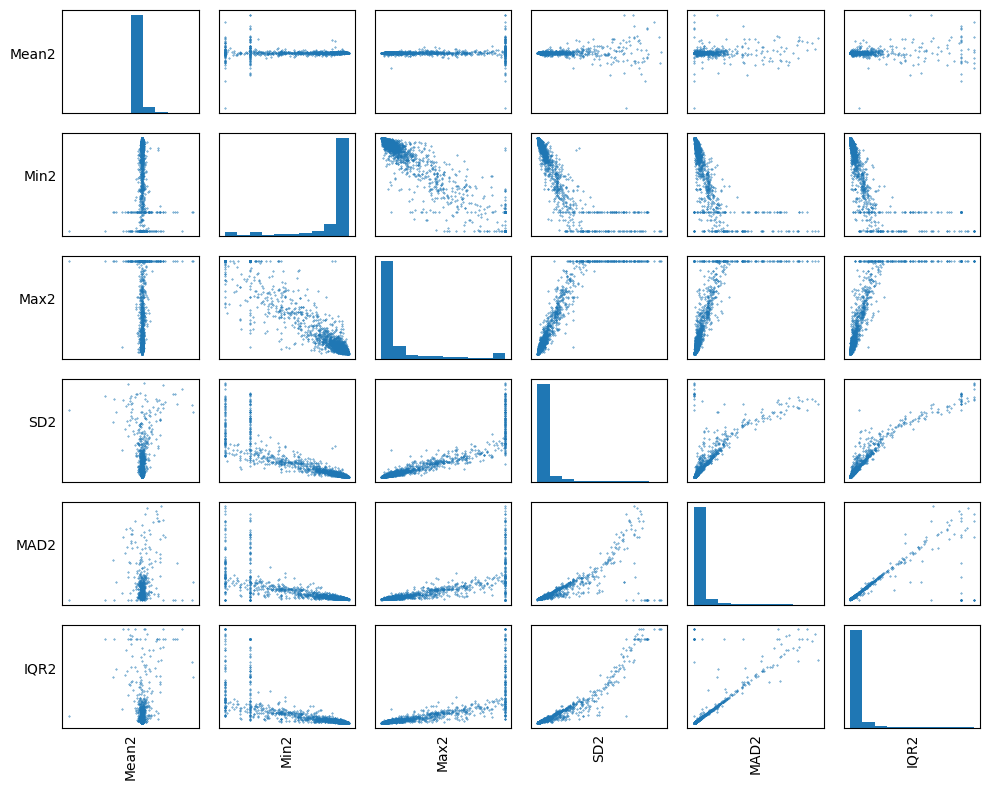

In [22]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
for ch in [2]:
    tmp_features = [ plate % ch for plate in ['Mean%d','Min%d','Max%d','SD%d', 'MAD%d', 'IQR%d']]
    scatter_plot_features(featured_df, tmp_features, results_dir, 'simple_stats', with_jitter=False, jitter=1e-1)


### Inspecting highly correlating `info` feature pairs

In [23]:
featured_df.columns

Index(['participant', 'condition', 'window index', 'Correlation0',
       'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4',
       'Correlation5', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'MAD0', 'MAD1', 'MAD2',
       'MAD3', 'Max0', 'Max1', 'Max2', 'Max3', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'Min0', 'Min1', 'Min2', 'Min3', 'SD0', 'SD1', 'SD2', 'SD3',
       'Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1',
       'Hurst_H2', 'Hurst_H3', 'LempelZivComplexity[b=1]',
       'LempelZivComplexity[b=2]', 'LempelZivComplexity[b=4]',
       'LempelZivComplexity[b=8]', 'LyapunovExponent0', 'LyapunovExponent1',
       'LyapunovExponent2', 'LyapunovExponent3', 'SampleEntropy[m=2][0]',
       'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]',
       'SampleEntropy[m=2][3]', 'arCoeff0', 'arCoeff1', 'arCoeff10',
       'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15',
       'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7',
    

Saving scatter plot features to ../data/results/dreem_4secs/scatter_plot_features_arCoeff.png


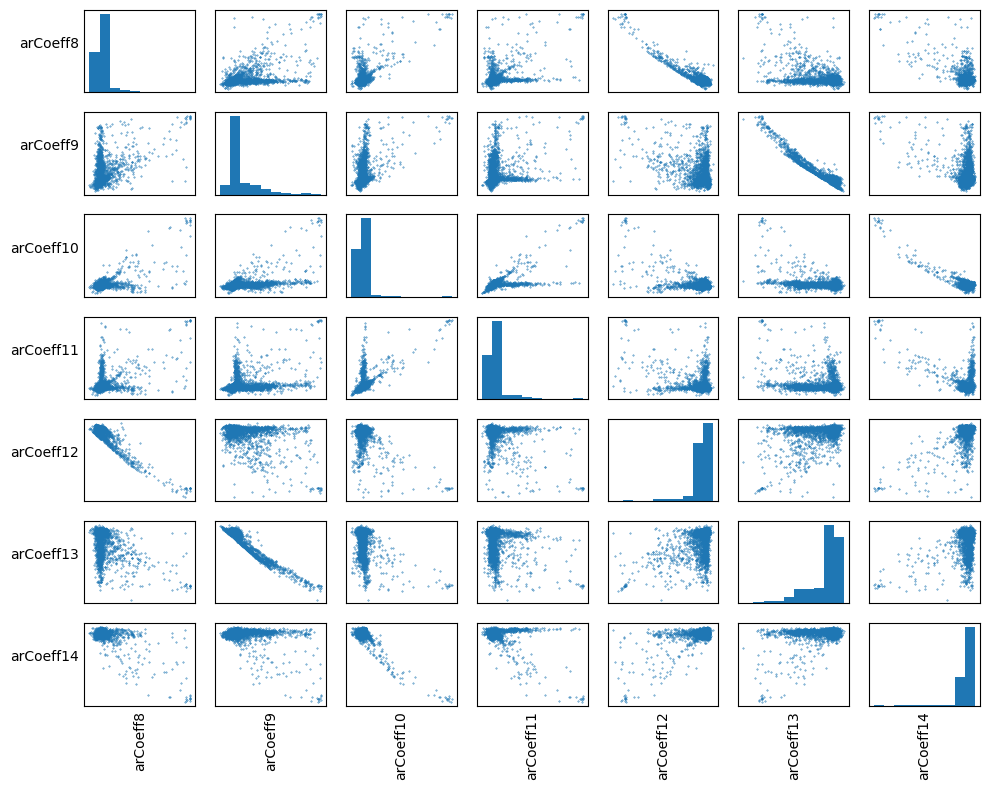

In [24]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f'arCoeff{d}' for d in range(8,15) ]
scatter_plot_features(featured_df, tmp_features, results_dir, 'arCoeff', with_jitter=False, jitter=1e-1)


tmp_features = ['SampleEntropy[m=2][0]', 'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]', 'SampleEntropy[m=2][3]']
Saving scatter plot features to ../data/results/dreem_4secs/scatter_plot_features_SampleEntropy.png


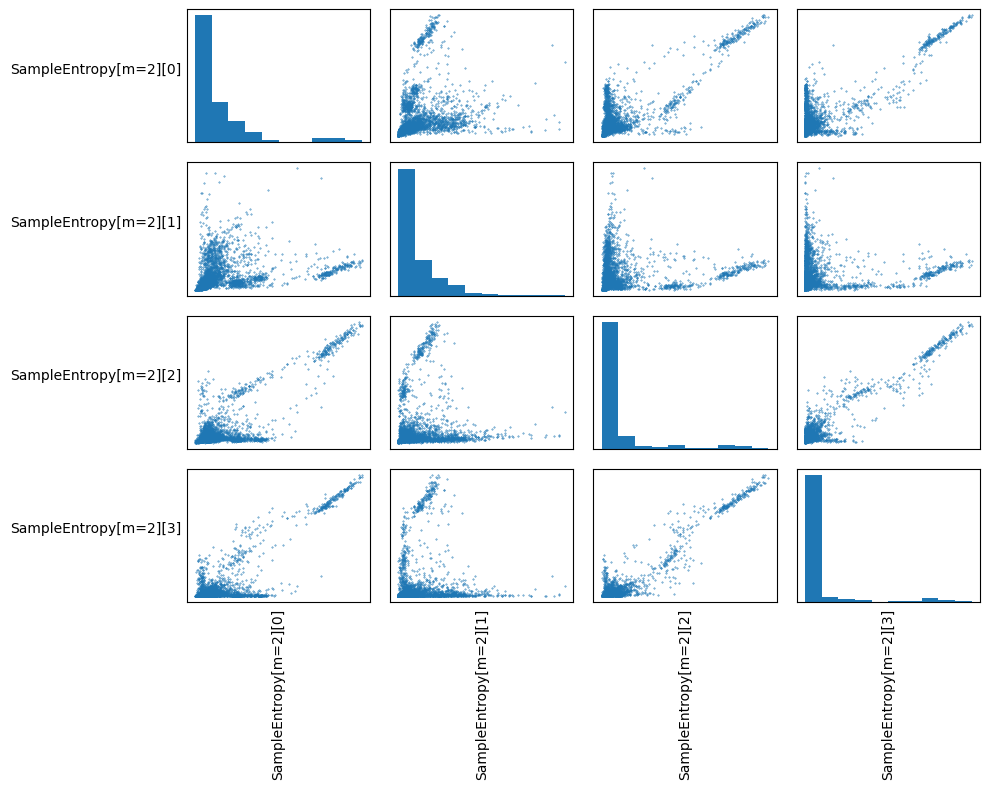

In [25]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f for f in featured_df.columns if f.startswith('SampleEntropy') ][:5]
print(f"tmp_features = {tmp_features}")
scatter_plot_features(featured_df, tmp_features, results_dir, 'SampleEntropy', with_jitter=False, jitter=1e-1)


tmp_features = ['Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1', 'Hurst_H2', 'Hurst_H3']
Saving scatter plot features to ../data/results/dreem_4secs/scatter_plot_features_Hurst.png


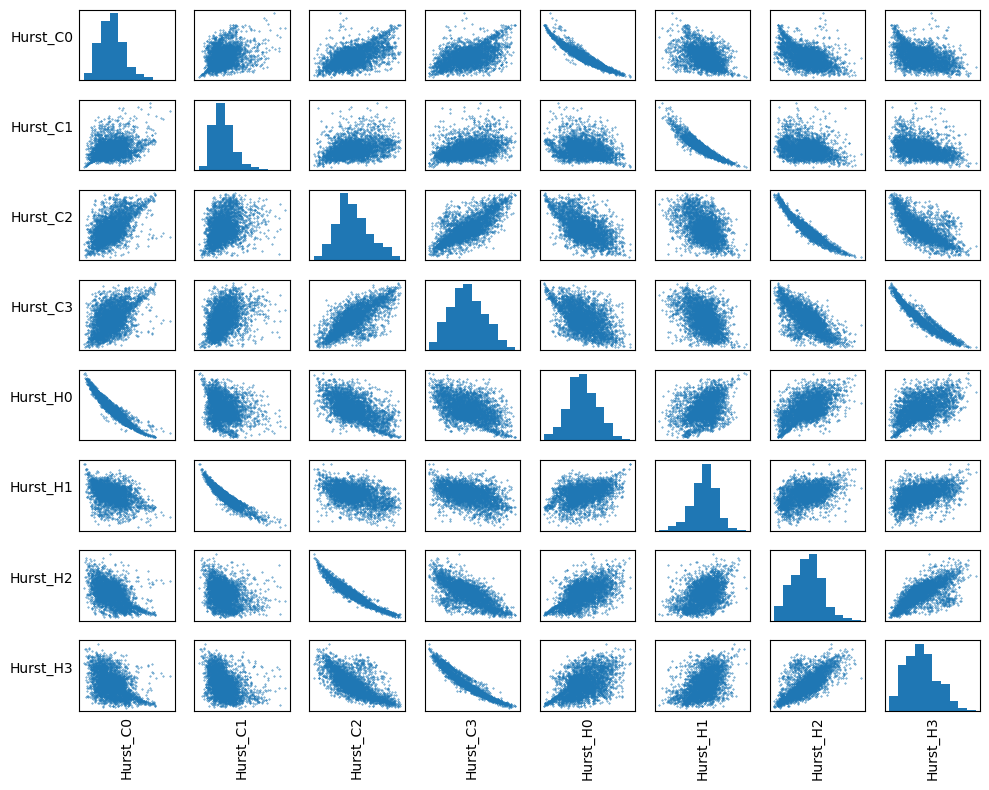

In [26]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f for f in featured_df.columns if f.startswith('Hurst') ]
print(f"tmp_features = {tmp_features}")
scatter_plot_features(featured_df, tmp_features, results_dir, 'Hurst', with_jitter=False, jitter=1e-1)


In [27]:
featured_df.columns

Index(['participant', 'condition', 'window index', 'Correlation0',
       'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4',
       'Correlation5', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'MAD0', 'MAD1', 'MAD2',
       'MAD3', 'Max0', 'Max1', 'Max2', 'Max3', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'Min0', 'Min1', 'Min2', 'Min3', 'SD0', 'SD1', 'SD2', 'SD3',
       'Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1',
       'Hurst_H2', 'Hurst_H3', 'LempelZivComplexity[b=1]',
       'LempelZivComplexity[b=2]', 'LempelZivComplexity[b=4]',
       'LempelZivComplexity[b=8]', 'LyapunovExponent0', 'LyapunovExponent1',
       'LyapunovExponent2', 'LyapunovExponent3', 'SampleEntropy[m=2][0]',
       'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]',
       'SampleEntropy[m=2][3]', 'arCoeff0', 'arCoeff1', 'arCoeff10',
       'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15',
       'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7',
    

Saving scatter plot features to ../data/results/dreem_4secs/scatter_plot_features_LempelZiv.png


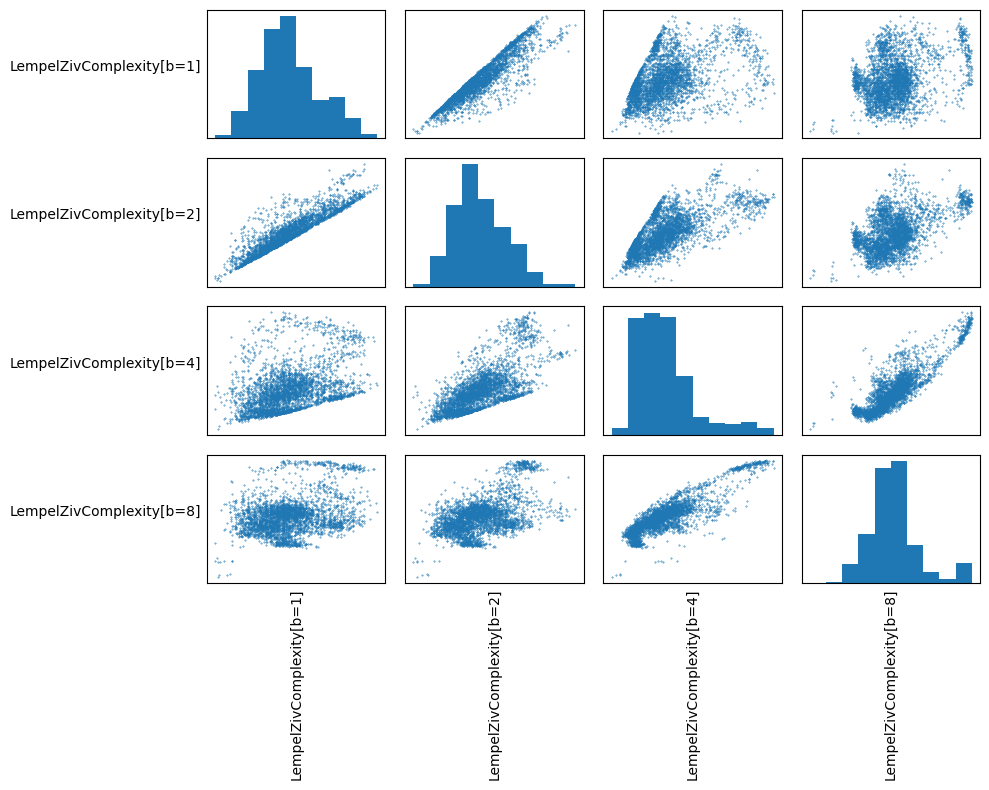

In [28]:
try:
    # entropy and complexity correlations
    # for ch in [0,1,2,3]:
    tmp_features = [ f for f in featured_df.columns if f.startswith('LempelZiv') ]
    tmp_features.sort()
    scatter_plot_features(featured_df, tmp_features, results_dir, 'LempelZiv', with_jitter=False, jitter=1e-1)
    
except:
    print("Skipping correlation analysis as not enough features")

In [29]:
# # entropy and complexity correlations
# # for ch in [0,1,2,3]:
# tmp_features = [ plate % ch for ch in range(4) for plate in ['Hurst_H%d','Hurst_C%d'] ]
# scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


### Inspecting highly correlating `stats` feature pairs

In [30]:
# entropy and complexity correlations
try:
    tmp_features = [ plate % ch for ch in [0,1,2,3] for plate in ['MeanFreq%d','FreqSkewness%d']]
    scatter_plot_features(featured_df, tmp_features, results_dir, 'freq', with_jitter=False, jitter=1e-1)
except:
    pass